<a href="https://colab.research.google.com/github/nhuang37/dimensionality_reduction/blob/main/Projections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment (Section 7.2): Comparison of projection-based methods and the choice of $k$

#### authors
- **David W Hogg** *(NYU) (MPIA) (Flatiron)*
- **Soledad Villar** *(JHU)* 
- **Ningyuan (Teresa) Huang** *(JHU)*

#### license
Copyright 2021 the authors. All rights reserved (for now).

In [1]:
import numpy as np
import pylab as plt
from sklearn import linear_model as lm
%matplotlib inline

In [2]:
def make_Cxx(p, model='I', decay='exp', a=1):
  '''
  Caution: assume data is from Gaussian, so the covariance can be taken as diagonal matrix 
  Return the true covariance Cxx
  p: number of covariates (features)
  model: covariance structure - identity/diagonal/general/planted gap
  decay: eigenvalue decay (for diagonal)
  a: parameter to control eigenvalue decay speed
  '''
  np.random.seed(0)
  assert model in ['I','D','GAP'], "model must be I/D/GAP"
  
  if model=='I':
    #random psd matrix
    cov = np.eye(p)
  elif model =='D':
    if decay == 'exp':
      cov = np.diag(np.exp(-a * np.arange(p)))
    else: #polynomial decay
      cov = np.diag(1/(np.arange(1,p+1))**a)
  elif model == 'GAP':
    rand_mat = np.random.normal(size=(p,p)) #np.random.rand(p,p)
    cov = rand_mat @ rand_mat.T
    u, ss, v = np.linalg.svd(cov)
    s = ss / ss[0]
    sneakyKhack = 16
    s[sneakyKhack:] = 1e-2 * s[sneakyKhack:]
    cov = np.diag(s) #(u * s) @ v
  else:
    raise NotImplementedError("To be implemented")    
  return cov

def make_beta(p, alignment='weak', isotropic=False):
    '''
    Return the true coefficient with a constant norm 1
    p: number of covariates (features)
    alignment: weak => uniform signal; otherwise => large coefficient with small eigenvalue components
    '''
    np.random.seed(0)
    if isotropic: #(isotropic case)
      return np.random.normal(size=p)
    if alignment=='weak':
      return np.ones(p)
    else:
      base = np.arange(1, p+1)
      return base

def make_data(Cxx, beta, n, sigma):
    '''
    Return the training data tuple (Y, X): Y \in \R^n, X \in \R^{n x p}
    Cxx: population covariance
    beta: true param
    n: number of training examples
    sigma: noise standard deviation
    '''
    p = Cxx.shape[0]
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=Cxx, size=n)
    noise = np.random.normal(loc=0, scale=sigma, size=n)
    Y = X @ beta + noise
    return Y, X


In [3]:

def train_test_data(Ntrial, n, n_test, p, Cxx, beta, SNR):
  np.random.seed(8675309 + 1)
  # compute noise std
  sigma = np.linalg.norm(beta)/SNR
  # make maximal train and test sets
  X_MC = np.zeros((Ntrial, n, p))
  Y_MC = np.zeros((Ntrial, n))
  for trial in range(Ntrial):
    Y_MC[trial], X_MC[trial] = make_data(Cxx, beta, n, sigma)

  X_tests = np.zeros((Ntrial, n_test, p))
  Y_tests = np.zeros((Ntrial, n_test))
  for trial in range(Ntrial):
    Y_tests[trial], X_tests[trial] = make_data(Cxx, beta, n_test, sigma)
  return Y_MC, X_MC, Y_tests, X_tests, Cxx, beta, SNR, sigma


In [4]:
import scipy
from sklearn import linear_model


def mse(x):
  return np.mean(x * x)

def risk_bias_var(y_pred, y_true, beta, C_xx, SNR, method, X, X_p, proj_h, var_comp="indirect", rcond=1e-15, decomp=True):
  '''
  Return:
  - MSE: mean square error of predicted Y for different methods
  If decomp == True:
    - Bias: expected bias term conditioned on training data X
    - Variance: expected variance term conditioned on training data X

  Caution: 
  - MSE approximately equals to Bias + Variance (not exact, as the bias and variance expression is from the close-form risk)
  - Variance is computed indirectly by default, by subtrating bias from MSE. The direct computation suffers from numeric issues when k=n, and pinv(X_p)

  Params:
  y_pred, y_true: predicted labels; true labels
  beta, C_xx: true beta, true covariance matrix
  SNR: signal-to-noise ratio, norm(beta)/sigma
  projector: p by p matrix (excpet for random projection: p by k matrix)
  method: projection method
  X: original training data
  X_p: projected training data, X_p = X @ projector, n by p (except for random projection: n by k matrix)
  proj_h: projection matrix, p by p (except for random projection: p by k)
  var_comp: "indirect" vs "direct" ("direct" is numerically unstable & slow, as it involves inverting the ill-conditioned empirical covariance matrix)
  rcond: parameter when doing "direct" variance computation
  
  '''
  risk = mse(y_pred - y_true)
  if decomp == False: #ortho-ridge model
    return risk
   
  sigma_squared = (np.linalg.norm(beta)/SNR)**2
  n, k = X_p.shape
  p = C_xx.shape[0] 

  if n == k: #ill-conditioned matrix, need a large rcond (but still might suffer from numeric stability)
    rcond = 1e-5
  X_p_dagger = scipy.linalg.pinv(X_p, rcond=rcond)
  proj_perp = np.eye(p) - proj_h @ X_p_dagger @ X # size p by p (proj_H @ X_p_dagger is always p by p)
  bias_squared = ( (np.sqrt(C_xx) @ proj_perp @ beta)**2 ).sum()
  if var_comp =="direct":
    X_dagger =  np.linalg.pinv(X_p.T @ X_p, hermitian=True, rcond=rcond)
    variance = sigma_squared * np.trace(X_dagger @ C_xx) 
  else:
    variance = risk - bias_squared - sigma_squared
  return risk, bias_squared, max(0,variance)

def rand_projector(p, maxH, trial=0):
  '''
  Return: p by maxH random matrix
  '''
  np.random.seed(111 + trial)
  return np.random.multivariate_normal(mean=np.zeros(p), cov=(1/p)*np.eye(p), size=maxH).T

def ortho_projector(p, K, trial=0):
  '''
  Return: p by p orthogonal matrix with rank K
  '''
  np.random.seed(111 + trial)
  a = np.random.normal(size=(p,K)) #np.random.random(size=(p, K))
  q, _ = np.linalg.qr(a) #q: n by K
  if K < p:
    q = np.concatenate((q, np.zeros((p,p-K))),axis=1)
  return q 

def oracle_projector(p, K):
  '''
  Return: p by p matrix with rank K, where the first k by k submatrix is the identity, and zero elsewhere
  Warning: only works for Gaussian data w/ diagonal covariance matrix due to rotation invariance!
  '''
  u_true = np.eye(p)[:, :K]
  return u_true @ u_true.T

def pca_projector(xs, K):
  '''
  Return: p by p matrix with rank K, same basis with the training data X
  '''
  u, s, v = np.linalg.svd(xs, full_matrices=False)
  v = v[:K, :]
  return v.T @ v

def pls_projector(xs, y, K, stable=True):
  '''
  Return: p by p matrix with rank K, the Krylov space approximation
  '''
  A = xs.T @ xs #p x p
  b = xs.T @ y  #p x 1
  krylov = [b]
  for i in range(1,K):
    b = A @ b #power iteration
    krylov.append(b)
  q, r = np.linalg.qr(np.array(krylov).T) #obtain orthornomal basis of krylov space, q = p x K, r = K X K
  if stable: #numerical issue
    L = q.T @ A @ q #tri-diagonal, K X K
    try:
      u_r, s_r, v_r = np.linalg.svd(L, full_matrices=False) #U shape: K X K
    except ValueError:
      print("PLS numeric issue: krylov projection matrix has nan/inf value")
      return np.nan
    else:
      ritz = q @ u_r #shape: p x K
      return ritz @ ritz.T
  else:
    return q @ q.T #rank-K

def get_lstsq(A, b, k, rcond):
  '''
  A = X Pi, the projected data
  b = y
  '''
  x, _, rank, _ = np.linalg.lstsq(A, b, rcond=rcond) 
  assert rank == k, "get_lstsq(): rank {} must be the same as k {}".format(rank, k) 
  return x.T

def get_ridge(xs, y):
  '''
  Return ridge estimator from leave-one-out-cross-validation to search for lambda
  '''
  ridge_est = linear_model.RidgeCV(alphas=10.0**np.arange(-4,4,.1), fit_intercept=False)
  ridge_est.fit(xs, y)
  return ridge_est.coef_

def MSE_proj(datasets, hs, method='PCA', random_avg=True, rcond_param=0, bias_var_decomp=False):
  '''
  Return:
  - [Default] MSE (average over Monte-Carlos) for different projection methods
  - If bias_var_decomp is True: (MSE, bias, variance)

  Params:
  datasets: (Y_trains, X_trains, Y_tests, X_tests)
  hs: range to search over hidden/projection dimension
  method: 
  'PCA' - PCA-OLS; 'PLS' - Partial Least Squares  ;
  'rand' - Random Gaussian Projection (Ba et al); 'ortho' - Orthogonal Projection (Lin et al, TBI); 'oracle' - oracle-PCR (Xu and Hsu 2019);
  'null' - beta := np.zeros(p)
  'ortho-ridge': Orthogonal Projection with ridge regularization, where ridge param is chosen by leave-one-out-cross-validation
  '''
  Y_train, X_train, Y_test, X_test, Cxx, beta, SNR, sigma = datasets
  Ntrial = Y_train.shape[0]
  n, p = X_train[0].shape 
  maxH = hs[-1]
  results, Bs, Vs = [], [], []

  if method == 'null': #all zeros, trivial benchmark
    for t in range(Ntrial):
      error = mse(Y_test[t])
      MSE_h = [error] * len(hs)
      results.append(MSE_h)
    if bias_var_decomp:
      return results, results, [0]*Ntrial
    else:
      return results

  else: #nontrivial methods
    if method == 'rand': #avg over random projection matrices
      W_list = [rand_projector(p,maxH,trial) for trial in range(5)]

    for t in range(Ntrial):
      MSE_h, bias_h, var_h = [], [], []
      for h in hs:
        #check the maximum rank possible
        maxRank = min(n, p, h)
        if method == 'rand':
          Proj_list = [W[:,:h] for W in W_list] 
        elif method == 'PCA':
          Proj_h = pca_projector(X_train[t], h)
        elif method == 'PLS':
          Proj_h = pls_projector(X_train[t], Y_train[t], h)
        elif method in ['ortho', 'ortho-ridge']:
          Proj_list = [ortho_projector(p, h, trial) for trial in range(5)]
        elif method == 'oracle':
          Proj_h = oracle_projector(p, h)
        else:
          raise NotImplementedError("To be implemented")
        
        if (method == 'PLS') and isinstance(Proj_h, float):
          error = np.nan #bug: to be clean up

        elif method in ['rand', 'ortho', 'ortho-ridge']: #slow - to be cleaned up
          error, err_B, err_V = [], [], []
          for Proj_h in Proj_list:
            X_p = X_train[t] @ Proj_h
            if method == 'ortho-ridge':
              alpha = get_ridge(X_p, Y_train[t])
            else:
              alpha = get_lstsq(X_p, Y_train[t], maxRank, rcond_param)
            hat_beta_proj = Proj_h @ alpha
            #MSE on test set
            Y_test_pred = X_test[t] @ hat_beta_proj
            mean_squared_err, bias2, variance = risk_bias_var(Y_test_pred, Y_test[t], beta, Cxx, SNR, method, X_train[t], X_p, Proj_h)
            error.append(mean_squared_err) 
            err_B.append(bias2)
            err_V.append(variance)
          #random projection: average over random initialized weights
          error = np.array(error).mean()       
          err_B = np.array(err_B).mean()   
          err_V = np.array(err_V).mean()   
        
        else:
          #PCA , oraclePCR or well-conditioned PLS
          X_p = X_train[t] @ Proj_h
          alpha = get_lstsq(X_p, Y_train[t], maxRank, rcond_param)
          hat_beta_proj = Proj_h @ alpha
          #MSE on test set
          Y_test_pred = X_test[t] @ hat_beta_proj
          error, err_B, err_V = risk_bias_var(Y_test_pred, Y_test[t], beta, Cxx, SNR, method, X_train[t], X_p, Proj_h)

        MSE_h.append(error)
        bias_h.append(err_B)
        var_h.append(err_V)
      results.append(MSE_h)
      Bs.append(bias_h)
      Vs.append(var_h)

    if bias_var_decomp:
      return results, Bs, Vs
    else:
      return results


In [5]:
def simulation(n, p, SNR, Ntrial, n_test,beta, hs, methods, rand_avg_flag, rcond, bv_tradeoff):
  ###Create different datasets, a tuple of Y_MC, X_MC, Y_tests, X_tests, Cxx
  #ba et al setting (Cxx = I, beta= weak) - favor random projection
  Cxx = make_Cxx(p)
  DS_ba = train_test_data(Ntrial, n, n_test, p, Cxx, beta, SNR)

  #Eigenvalue decay setting (Cxx = D, beta=weak)
  Cxx_d = make_Cxx(p, model='D') #exponential decay
  DS_CxxExp = train_test_data(Ntrial, n, n_test, p, Cxx_d, beta, SNR)

  #Eigenvalue decay setting (Cxx = D, beta=weak)
  Cxx_d_poly = make_Cxx(p, model='D', decay='poly', a=2) #polynomial decay
  DS_CxxPoly = train_test_data(Ntrial, n, n_test, p, Cxx_d_poly, beta, SNR)

  #Eigenvalue general setting (Cxx = A, beta=weak)
  Cxx_A = make_Cxx(p, model='GAP') #gap
  DS_CxxA = train_test_data(Ntrial, n, n_test, p, Cxx_A, beta, SNR)

  ###Run simulation: different datasets with different methods
  DS_name = ['isotropic covariance', 'gapped covariance', 'exponential decay', 'polynomial decay' ]
  DATA = [DS_ba, DS_CxxA, DS_CxxExp, DS_CxxPoly]
  results, Bs, Vs = defaultdict(defaultdict), defaultdict(defaultdict), defaultdict(defaultdict)

  for (datasets, name) in zip(DATA, DS_name):
    for method in methods:
      if bv_tradeoff: 
        results[name][method], Bs[name][method], Vs[name][method] = MSE_proj(datasets, hs, method, rand_avg_flag, rcond, bv_tradeoff)
      else:
        results[name][method] = MSE_proj(datasets, hs, method, rand_avg_flag, rcond)
  return results, Bs, Vs

###PLOT
def plot(results, methods, hs, xticks, xticklabels): 
  colors = {methods[0]: 'tab:blue', methods[1]: 'tab:pink', methods[2]: 'tab:orange', methods[3]: 'tab:green',
            methods[4]: 'tab:purple', methods[5]: 'tab:gray', methods[6]: 'tab:cyan'}
  captions = {'PCA': 'PCA-OLS', 'PLS': 'PLS', 'rand': 'random', 'ortho': 'orthogonal',
              'oracle': 'oracle-PCR', 'null': 'null', 'ortho-ridge': 'ortho+ridge'}
  fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True,figsize=(10,6),dpi=120)
  axs = axs.ravel()

  for i, (ds_key, value) in enumerate(results.items()):
    for j, (k, v) in enumerate(value.items()):
      if k == 'null':
        axs[i].axhline(np.nanmean(np.array(v)), label=captions[k], color=colors[k], linestyle=':' , alpha=0.5)
      else: 
        axs[i].plot(hs, np.nanmean(np.array(v),axis=0), label=captions[k], marker='o', markersize=3, color=colors[k], alpha=0.7)
    axs[i].axvline(n, color='gray', linestyle=':', alpha=0.5)
    axs[i].axvline(p, color='k', linestyle=':', alpha=0.5)
    axs[i].legend(fontsize=10, loc='upper right')
    axs[i].set_title(ds_key , fontsize=15)
    axs[i].set_yscale('log')
  fig.text(-0.02, 0.5, r'mean squared prediction error on held out data', va='center', rotation='vertical',fontsize=15)

  maxH = hs[-1]
  plt.setp(axs, xticks=xticks, xticklabels=xticklabels)
  axs[2].set_xlabel(r'k: projection dimension',fontsize=15)
  axs[3].set_xlabel(r'k: projection dimension',fontsize=15)

  fig.tight_layout()
  plt.show()  

In [6]:
from collections import defaultdict

rcond=None
rand_avg_flag = True
n=50
p=75
SNR = 16
Ntrial = 10
n_test = 2**8
beta = make_beta(p, alignment='weak', isotropic=True) 
hs = [1,3] + [i for i in range(5,2*(p+1), 5)] #np.arange(1, maxH, 10)
methods =  ['ortho',  'oracle', 'PCA', 'PLS', 'rand', 'null', 'ortho-ridge']
bv_flag = True

results_highSNR, Bs_highSNR, Vs_highSNR = simulation(n,p,SNR,Ntrial, n_test, beta, hs, methods, rand_avg_flag, rcond, bv_flag)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in matmul


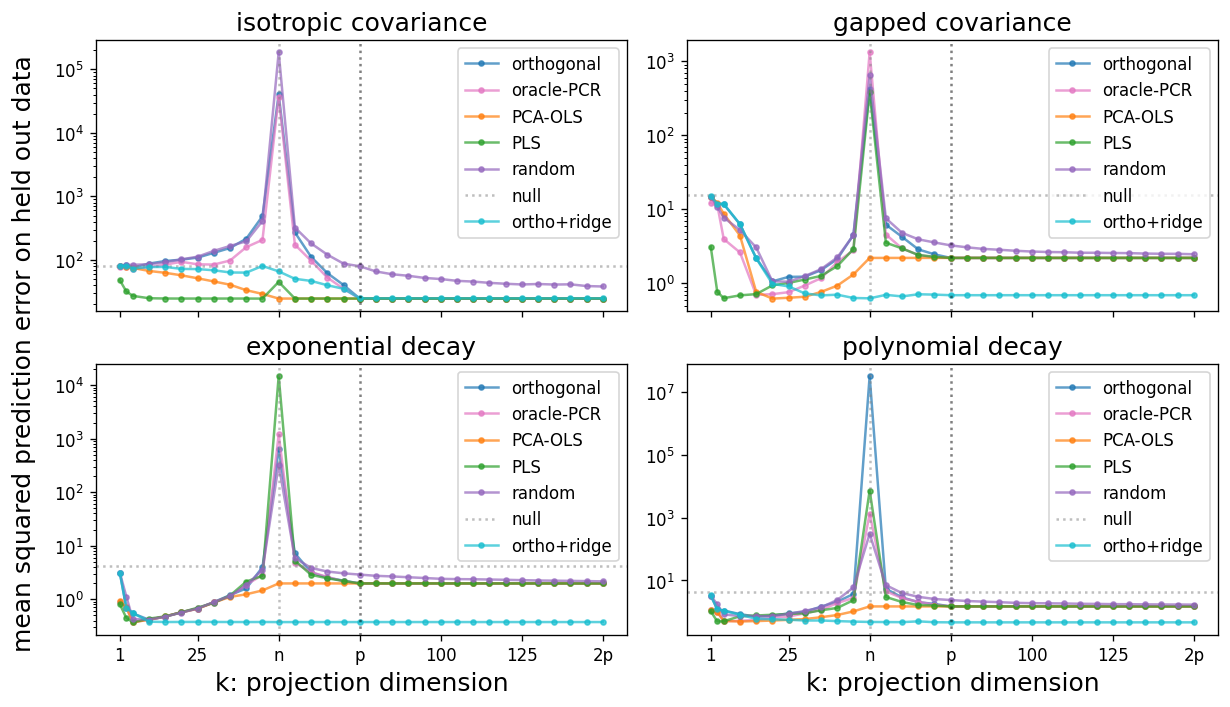

In [7]:
#truncate all methods except random when k >p 
maxH = 150
xticks = [1,25,n,p,100, 125, maxH]
xlabels = ['1','25','n','p','100','125','2p']
plot(results_highSNR, methods, hs, xticks, xlabels) 

#### High SNR: Bias_variance tradeoff

In [8]:
###PLOT
#results_highSNR, Bs_highSNR, Vs_highSNR

def plot_bv_tradeoff(MSEs, Bs, Vs, methods, hs, xticks, xticklabels): 
  col_titles = ['MSE', r'Bias$^2$', 'Variance']
  colors = {methods[0]: 'tab:blue', methods[1]: 'tab:pink', methods[2]: 'tab:orange', methods[3]: 'tab:green', methods[4]: 'tab:purple', methods[5]: 'tab:gray'}
  captions = {'PCA': 'PCA-OLS', 'PLS': 'PLS', 'rand': 'random', 'ortho': 'orthogonal', 'oracle': 'oracle-PCR', 'null': 'null'}
  fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True,figsize=(16,12),dpi=200)

  for col_id, results in enumerate([MSEs, Bs, Vs]): 
    for i, (ds_key, value) in enumerate(results.items()):
      for j, (k, v) in enumerate(value.items()):
        if k == 'null':
          axs[i, col_id].axhline(np.nanmean(np.array(v)), label=captions[k], color=colors[k], linestyle=':' , alpha=0.5)
        else: 
          axs[i, col_id].plot(hs, np.nanmean(np.array(v),axis=0), label=captions[k], marker='o', markersize=3, color=colors[k], alpha=0.7)
          if col_id == 0: #MSE: plot including the peak
            axs[i, col_id].set_ylabel(ds_key , va='center', rotation='vertical',fontsize=15, labelpad=10)
            axs[i, col_id].set_yscale('log')
          elif col_id == 2:
            axs[i, col_id].set_yscale('log')
          else:
            pass            

        axs[i, col_id].axvline(n, color='gray', linestyle=':', alpha=0.5)
        axs[i, col_id].axvline(p, color='k', linestyle=':', alpha=0.5)
        axs[i, col_id].legend(fontsize=10, loc='upper right')
    axs[-1, col_id].set_xlabel(r'k: projection dimension',fontsize=15)
    axs[0, col_id].set_title(col_titles[col_id],fontsize=15)

  ###deal with the y-axis limit
  axs[0,1].set_ylim(20,150)
  axs[1,1].set_ylim(-0.1,12)
  axs[2,1].set_ylim(-0.1,1.5)

  maxH = hs[-1]
  plt.setp(axs, xticks=[1,25,n,p,100, 125, maxH], xticklabels=['1','25','n','p','100','125','2p'])
  plt.show()  

In [9]:
k_loc = hs.index(n)
hs_nopeak = hs[:k_loc] + [n+1] + hs[k_loc+1:] #avoid n but use n-1 and n+1
methods_sub =  ['ortho',  'oracle', 'PCA', 'PLS', 'rand', 'null']
results_highSNR, Bs_highSNR, Vs_highSNR = simulation(n,p,SNR,Ntrial, n_test, beta, hs_nopeak, methods_sub, rand_avg_flag, rcond, bv_flag)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in matmul


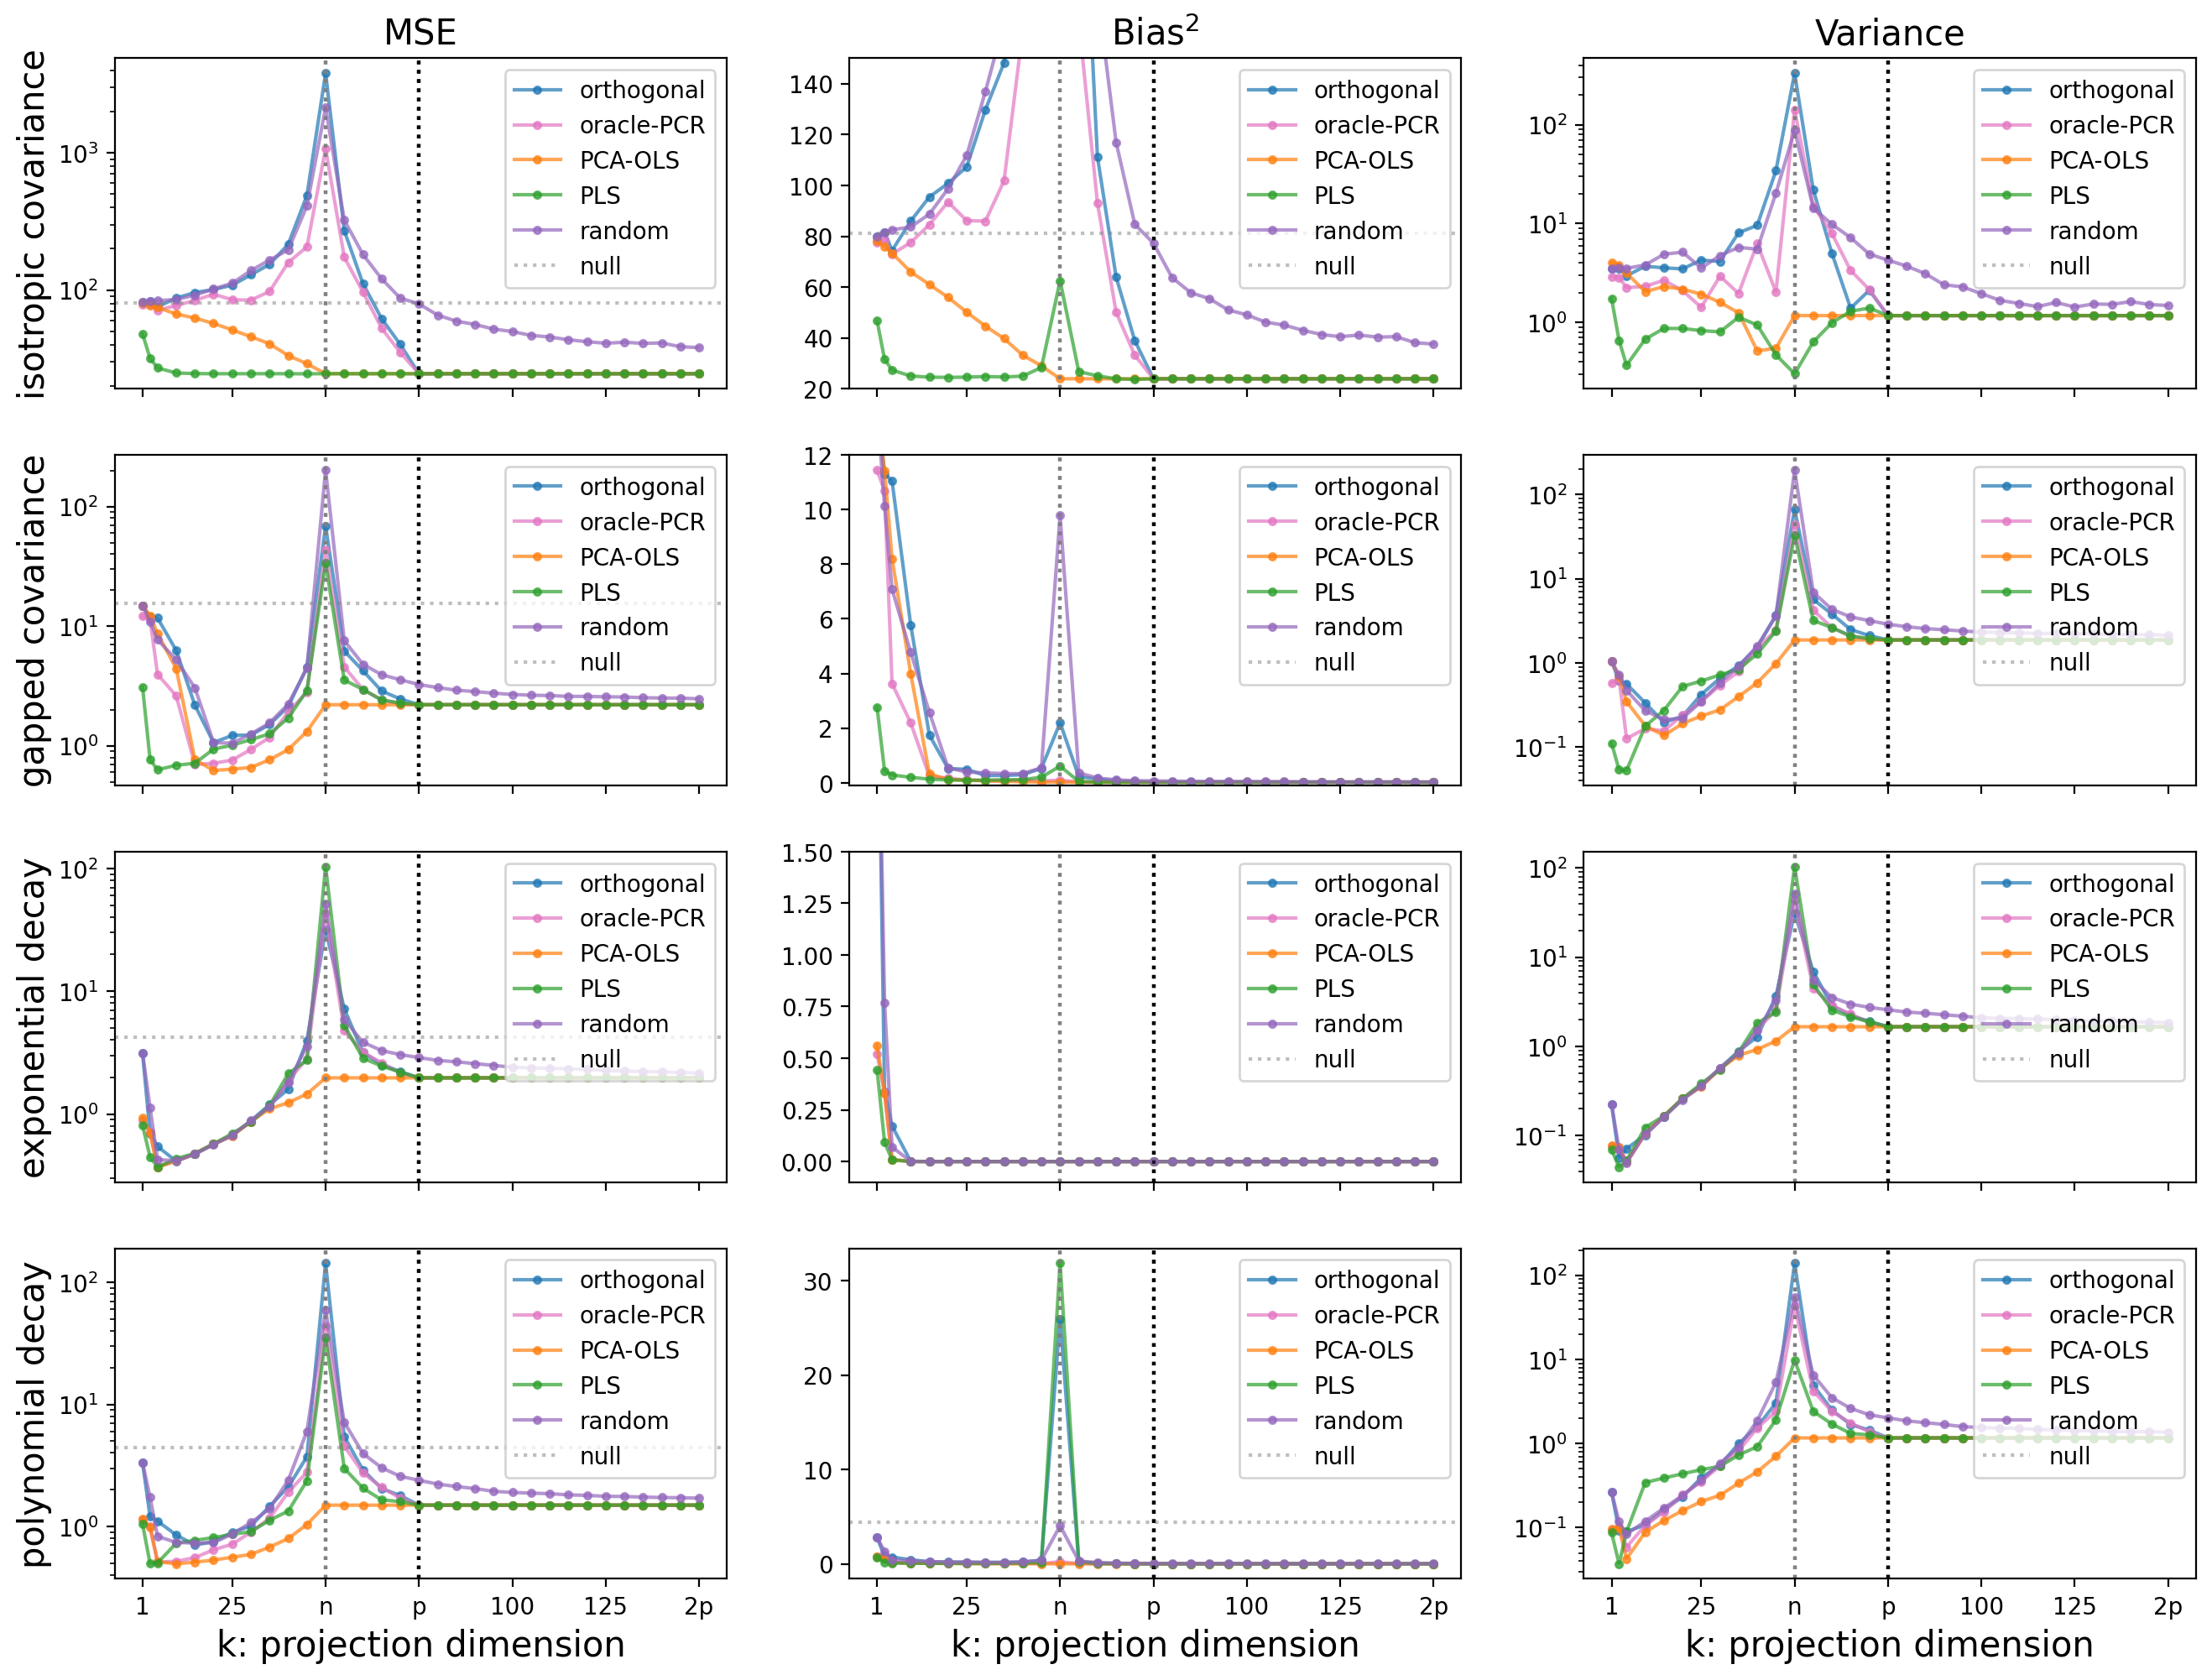

In [10]:
plot_bv_tradeoff(results_highSNR, Bs_highSNR, Vs_highSNR, methods, hs, xticks, xlabels)

### Other settings: 
- Low SNR
- Misaligned Beta

In [11]:
SNR_low = 2
results_lowSNR, _, _ = simulation(n,p,SNR_low,Ntrial, n_test, beta, hs, methods, rand_avg_flag, rcond, bv_tradeoff=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in matmul


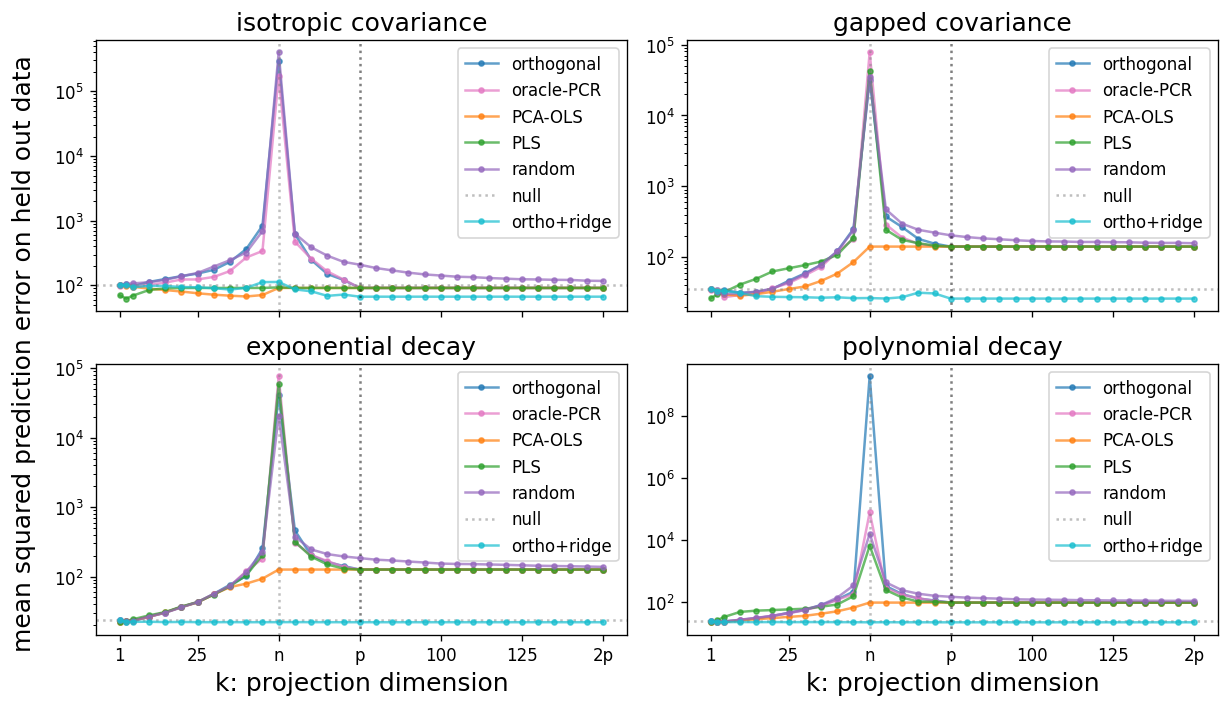

In [12]:
plot(results_lowSNR, methods, hs, xticks, xlabels)

In [13]:
#investigate beta!
beta_rev = make_beta(p, alignment='reverse')
SNR_higher = SNR * np.linalg.norm(beta_rev) / np.linalg.norm(beta)
results_highSNR_rev, Bs_rev, Vs_rev = simulation(n,p,SNR_higher,Ntrial, n_test, beta_rev, hs, methods,rand_avg_flag, rcond, bv_tradeoff=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in matmul


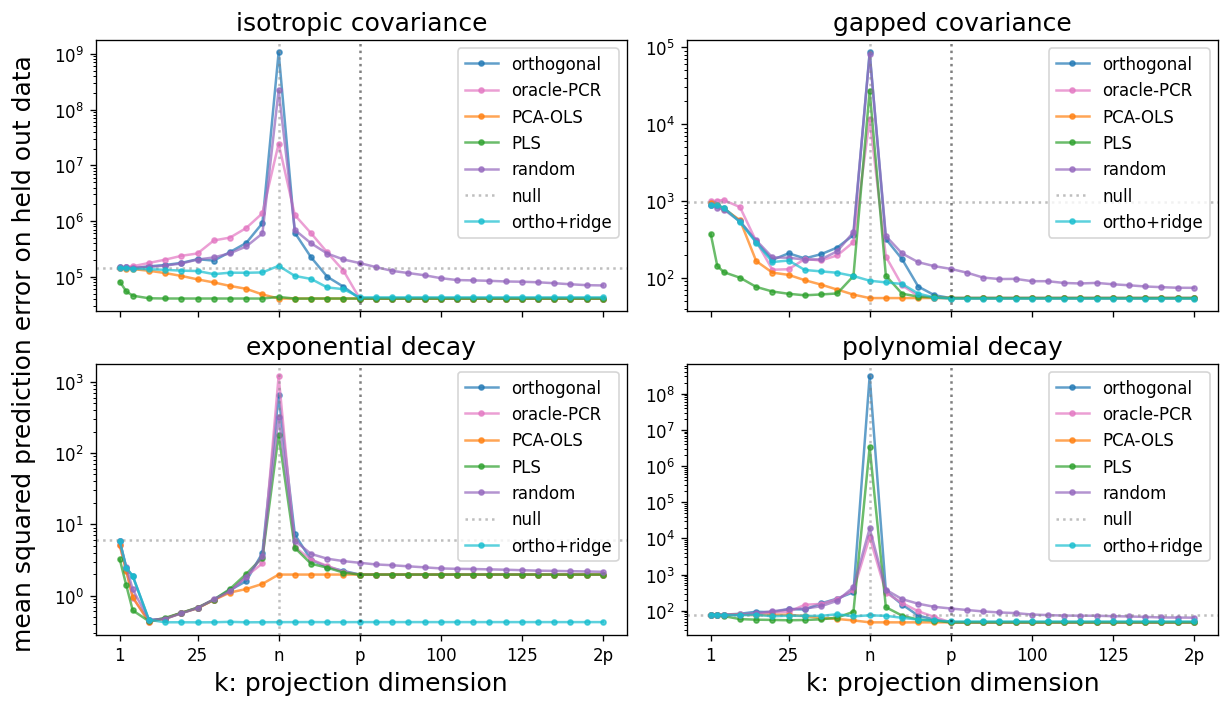

In [14]:
plot(results_highSNR_rev, methods, hs, xticks, xlabels)

### Data models visualization

In [15]:
#Plot eigenvalues
np.random.seed(0)
n=75
p=75
SNR = 16
Ntrial = 10
n_test = 2**8
beta = make_beta(p, alignment='weak')

Cxx = make_Cxx(p)
DS_ba = train_test_data(Ntrial, n, n_test, p, Cxx, beta, SNR)

#Eigenvalue decay setting (Cxx = D, beta=weak)
Cxx_d = make_Cxx(p, model='D') #exponential decay
DS_CxxExp = train_test_data(Ntrial, n, n_test, p, Cxx_d, beta, SNR)

#Eigenvalue decay setting (Cxx = D, beta=weak)
Cxx_d_poly = make_Cxx(p, model='D', decay='poly') #polynomial decay
DS_CxxPoly = train_test_data(Ntrial, n, n_test, p, Cxx_d_poly, beta, SNR)

#Eigenvalue general setting (Cxx = A, beta=weak)
Cxx_A = make_Cxx(p, model='GAP') #gap
DS_CxxA = train_test_data(Ntrial, n, n_test, p, Cxx_A, beta, SNR)

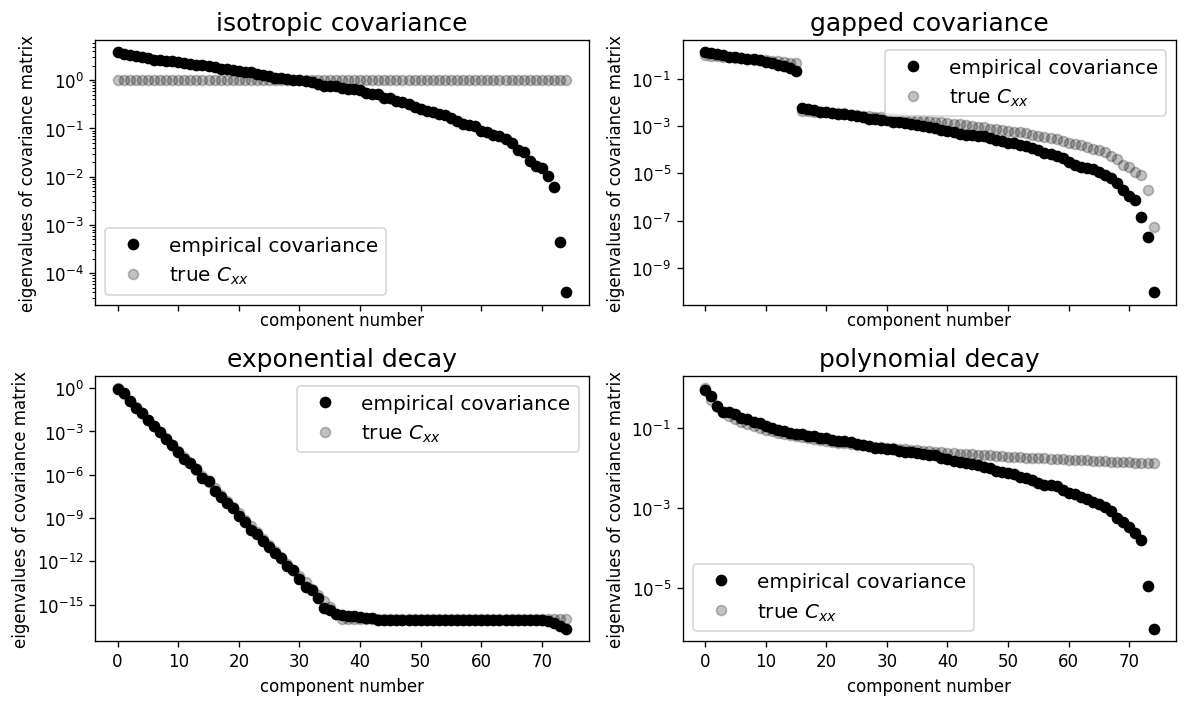

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10,6),dpi=120)
axs = axs.ravel()
DS_name = ['isotropic covariance', 'gapped covariance', 'exponential decay', 'polynomial decay' ]
for i, DS in enumerate([DS_ba, DS_CxxA, DS_CxxExp, DS_CxxPoly]):
    Y_MC, X_MC, Y_tests, X_tests, Cxx, _, _, _ = DS
    hat_Cxx = (1/n)* (X_MC[0].T @ X_MC[0])
    u, s, v = np.linalg.svd(hat_Cxx, full_matrices=False)
    axs[i].plot(s, "ko", label='empirical covariance')
    uu, ss, vv = np.linalg.svd(Cxx)
    axs[i].plot(ss, "ko", alpha=0.24, label=r'true $C_{xx}$')
    axs[i].set_ylabel("eigenvalues of covariance matrix")
    axs[i].set_xlabel("component number")
    axs[i].set_title(DS_name[i], fontsize=15)
    axs[i].legend(fontsize=12)
    axs[i].semilogy()

fig.tight_layout()
plt.semilogy()
plt.show()  

### More comparison of PCA-OLS and oracle-PCR

In [18]:
def compute_var(vv, ss, Cxx, n, ks):
  var_ks = []
  for k in ks:
    cov_dagger = np.linalg.pinv(vv[:k,:].T @ np.diag(ss[:k]**2) @ vv[:k,:])
    var_ks.append(np.trace(cov_dagger @ Cxx))
  return var_ks

In [23]:
#interlacing of singular values: variance of oracle-PCR is larger than PCA-OLS
#gap covariance model
def variance_peak(n, p, ks):
    beta = make_beta(p, alignment='weak')
    #Eigenvalue general setting (Cxx = A, beta=weak)
    Cxx_A = make_Cxx(p, model='GAP') #gap
    DS_CxxA = train_test_data(Ntrial, n, n_test, p, Cxx_A, beta, SNR)
    Y_MC, X_MC, Y_tests, X_tests, Cxx_A, _, _, _ = DS_CxxA #DS_ba

    fig, axs = plt.subplots(ncols=2,figsize=(8,5),dpi=120)
    #plot the empirical eigenvalues
    X_o = X_MC[0]
    u_o, s_o, v_o =  np.linalg.svd(X_o, full_matrices=False)
    axs[0].plot(s_o, marker='o', color='red', label=r'$X$', alpha=0.6)
    var_pcas = compute_var(v_o, s_o, Cxx_A, n, ks)
    axs[1].plot(ks, var_pcas, label='PCA-OLS',marker='o', color='red',  alpha=0.6)

    var_pcrs = []
    for k in ks:
      u_k, s_k, v_k =  np.linalg.svd(X_o[:, :k], full_matrices=False)
      axs[0].plot(s_k, marker='x', linestyle = 'None', label=r'$X_{[:k]}, k=$'+str(k) )
      s_k = np.pad(s_k, (0, p-k), 'constant')
      v_k = np.pad(v_k, [(0, p - k), (0, p - k)], 'constant') 
      var_pcr_k = compute_var(v_k, s_k, Cxx_A, n, [k])
      var_pcrs.append(var_pcr_k)
      axs[1].plot(k, var_pcr_k, marker='x', markersize=10)

    axs[1].plot(ks, var_pcrs, color='gray', linestyle='-.', label='oracle-PCR')

    axs[0].semilogy()
    for i in range(2):
      axs[i].legend()
      axs[i].set_xlabel('k')

    axs[0].set_title(r"Empirical eigenvalues", fontsize=15)
    axs[1].set_title(r"Variance", fontsize=15)

    plt.show()

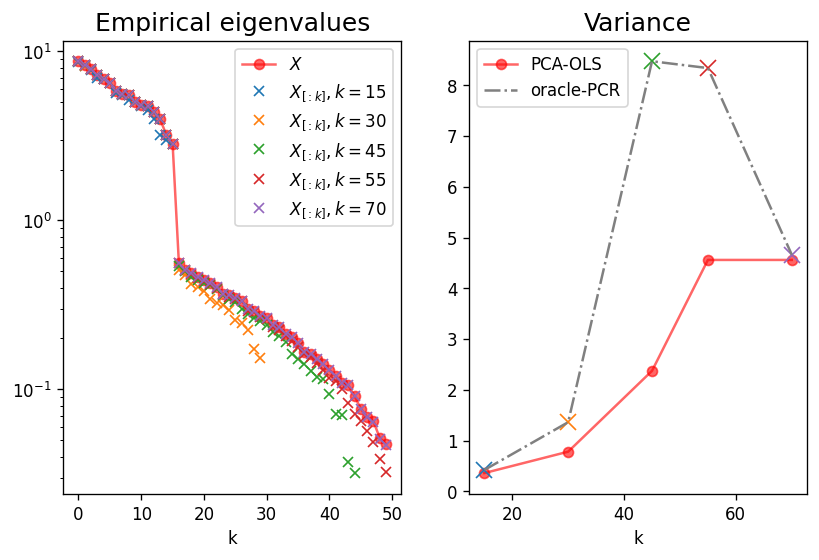

In [24]:
#Over-param: p>n 
#PCA-OLS is better when the dimensionality reduction is substantial
variance_peak(n=50, p=75, ks=[15,30,45,55,70])

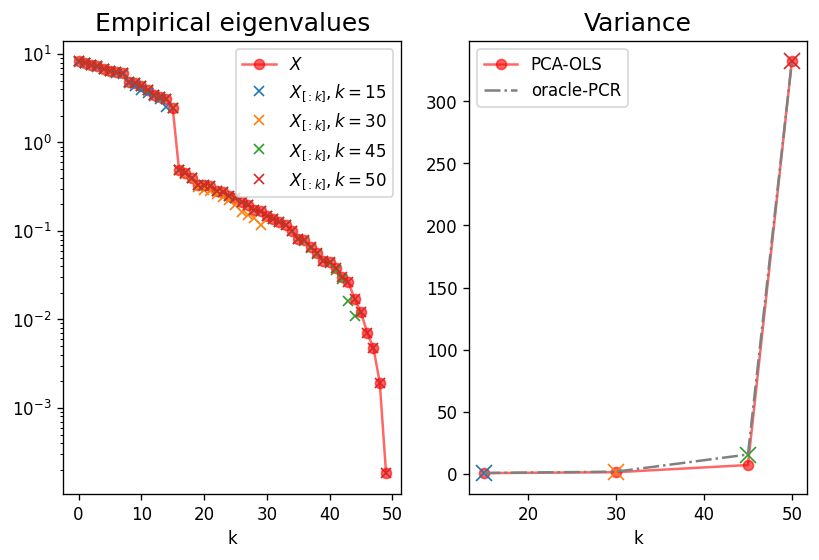

In [25]:
#Peak for both PCA and oracle-PCR when p=n (=k)
variance_peak(n=50, p=50, ks=[15,30,45,50])

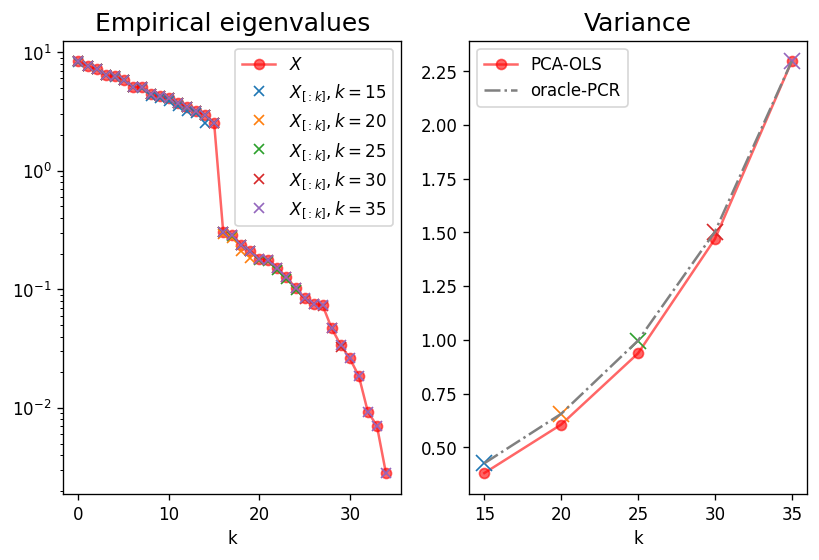

In [26]:
#n >> p: both are accuracte and converge to the truth
variance_peak(n=50, p=35, ks=[15,20,25,30,35])